In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import ElasticNet
import time

In [2]:
# Input Dataset 

# Define the directory where the parquet files are stored
parquet_directory = "CTU/"

# List all parquet files in the directory
parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith('.parquet')]

# Read each parquet file and append it to a list of DataFrames
dataframes = [pd.read_parquet(os.path.join(parquet_directory, file)) for file in parquet_files]

# Concatenate all DataFrames into a single DataFrame
DM = pd.concat(dataframes, ignore_index=True)

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10598771 entries, 0 to 10598770
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   dur        float32
 1   proto      object 
 2   dir        object 
 3   state      object 
 4   stos       float32
 5   dtos       float32
 6   tot_pkts   int32  
 7   tot_bytes  int64  
 8   src_bytes  int64  
 9   label      object 
 10  Family     object 
dtypes: float32(3), int32(1), int64(2), object(5)
memory usage: 727.8+ MB


In [4]:
#Feature Selection
features_to_drop = ['proto', 'dir', 'state', 'dtos', 'stos', 'tot_bytes', 'label','Family']

# Droping specified columns and target variable
X = DM.drop(features_to_drop, axis=1).values    
y = DM['label'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
# Membuat data yang multiclass menjadi binary class
attack_classes = [
    'flow=From-Botnet-V50-1-TCP-Established-SSL-To-Microsoft-1', 
    'flow=From-Botnet-V50-4-TCP-HTTP-Not-Encrypted-Down-2',
    'flow=From-Botnet-V42-UDP-DNS',
    'flow=From-Botnet-V42-TCP-HTTP-Google-Net-Established-6',
    'flow=From-Botnet-V42-TCP-Established',
    'flow=From-Botnet-V50-6-TCP-HTTP-Google-Net-Established-2'
]

# Mmebuat Label Binary
DM['binary_label'] = DM['label'].apply(lambda x: 1 if x in attack_classes else 0)

# Menampilkan rows 1 untuk mengkonformasi label baru
print(DM[['label', 'binary_label']].head())

# Menghitung label Binary
binary_counts = DM['binary_label'].value_counts()
print("Counts of binary labels:")
print(binary_counts)

# Menampilkan sample
print("Sample attack labels:")
print(DM[DM['binary_label'] == 1].head(10))  # Print 10 samples of attack labels
print("Sample benign labels:")
print(DM[DM['binary_label'] == 0].head(10))  # Print 10 samples of benign labels

                             label  binary_label
0      flow=Background-TCP-Attempt             0
1      flow=Background-TCP-Attempt             0
2  flow=Background-TCP-Established             0
3      flow=Background-TCP-Attempt             0
4      flow=Background-TCP-Attempt             0
Counts of binary labels:
binary_label
0    10573337
1       25434
Name: count, dtype: int64
Sample attack labels:
                 dur proto    dir     state  stos  dtos  tot_pkts  tot_bytes  \
1194283     0.000278   udp    <->       CON   0.0   0.0         2        203   
1194500     0.020525   udp    <->       CON   0.0   0.0         2        590   
1194505     0.045125   tcp     ->  SRPA_SPA   0.0   0.0         7        882   
1203011     0.336250   udp    <->       CON   0.0   0.0         2        215   
1203030  3514.083496   tcp     ->   SPA_SPA   0.0   0.0       120       7767   
1204099     0.459301   udp    <->       CON   0.0   0.0         2        212   
1204239     1.371909   udp    <-

In [7]:
# Apply Min-Max scaling to make X non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Encoding y dengan LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
# Elastic Net - Embedded
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.05)
elastic_net.fit(X_scaled, y_encoded)

ElasticNet(alpha=0.01, l1_ratio=0.05)

In [10]:
# Mendapatkan support dari Elastic Net (fitur yang koefisiennya tidak 0)
elastic_net_support = np.where(elastic_net.coef_ != 0)[0]

# Mengambil nama kolom dari X yang sudah difilter
filtered_columns = DM.drop(features_to_drop, axis=1).columns

features = []
for idx in elastic_net_support:
    print(f"Feature {filtered_columns[idx]} dengan koefisien Elastic Net {elastic_net.coef_[idx]}")
    features.append(filtered_columns[idx])

Feature dur dengan koefisien Elastic Net -415.22441581161655


In [11]:
# Tentukan 0.1% dari total dataset
total_samples = int(len(DM) * 0.001)

# Ambil jumlah minimal sampel dari kelas yang lebih sedikit
min_class_samples = DM['binary_label'].value_counts().min()

# Pastikan tidak mengambil lebih dari jumlah minimum kelas yang ada
if total_samples / 2 > min_class_samples:
    total_samples = min_class_samples * 2  # Sesuaikan total sampel agar tidak lebih dari yang tersedia

# Ambil sampel secara acak dari kedua kelas dengan jumlah yang seimbang
sampled_data = DM.groupby('binary_label').apply(lambda x: x.sample(n=int(total_samples / 2), random_state=42)).reset_index(drop=True)

# Cek distribusi kelas setelah sampling
print(sampled_data['binary_label'].value_counts())

hasil_threshold = []

binary_label
0    5299
1    5299
Name: count, dtype: int64


/tmp/ipykernel_5798/1383789099.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = DM.groupby('binary_label').apply(lambda x: x.sample(n=int(total_samples / 2), random_state=42)).reset_index(drop=True)


In [12]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = [0] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["binary_label"]

    # Untuk MalwareDataThreshold
    y_true_malware = [1] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["binary_label"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Elastic Net.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Elastic Net.csv'")

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.42s/it]

[['dur', 0, 0.0, 0.0, 0, 0.4997169277222117, 0.0067822933197021484], ['dur', 1, 0.9377240988865824, 0.6515012455749312, 0.7688380009283615, 0.7180600113228911, 0.005266904830932617], ['dur', 2, 0.9420645404793357, 0.6406570841889117, 0.7626613704071499, 0.70683147763729, 0.0052945613861083984], ['dur', 3, 0.9445178335535006, 0.6321040666835059, 0.7573579480971476, 0.697395735044348, 0.005169391632080078], ['dur', 4, 0.9482921305906775, 0.6282820705176294, 0.7558095811085208, 0.6936214380071711, 0.005269050598144531], ['dur', 5, 0.9494244197018306, 0.6259019656631003, 0.7544425283047163, 0.6909794300811474, 0.0052242279052734375], ['dur', 6, 0.9503679939611247, 0.6195866141732284, 0.750130334400834, 0.6834308360067938, 0.005223274230957031], ['dur', 7, 0.9520664276278543, 0.6100362756952842, 0.7436067506817009, 0.6717305151915456, 0.0051844120025634766], ['dur', 8, 0.9537648612945839, 0.6077441077441077, 0.7424164524421594, 0.6690885072655218, 0.0053081512451171875], ['dur', 9, 0.955463

In [14]:
HasilThreshold = pd.read_csv("Elastic Net.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Feature       3600 non-null   object 
 1   Threshold     3600 non-null   int64  
 2   Precision     3600 non-null   float64
 3   Recall        3600 non-null   float64
 4   F1_Score      3600 non-null   float64
 5   Accuracy      3600 non-null   float64
 6   Elapsed_Time  3600 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 197.0+ KB


In [15]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [16]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

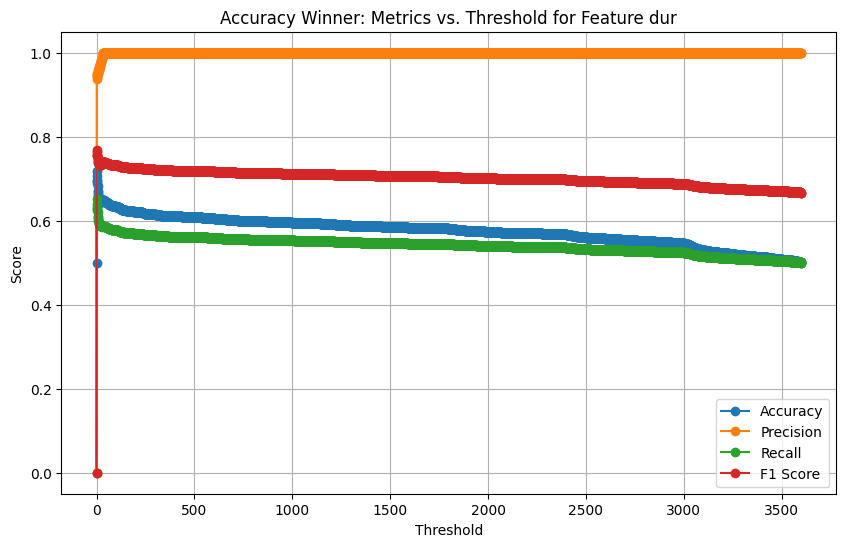

In [18]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

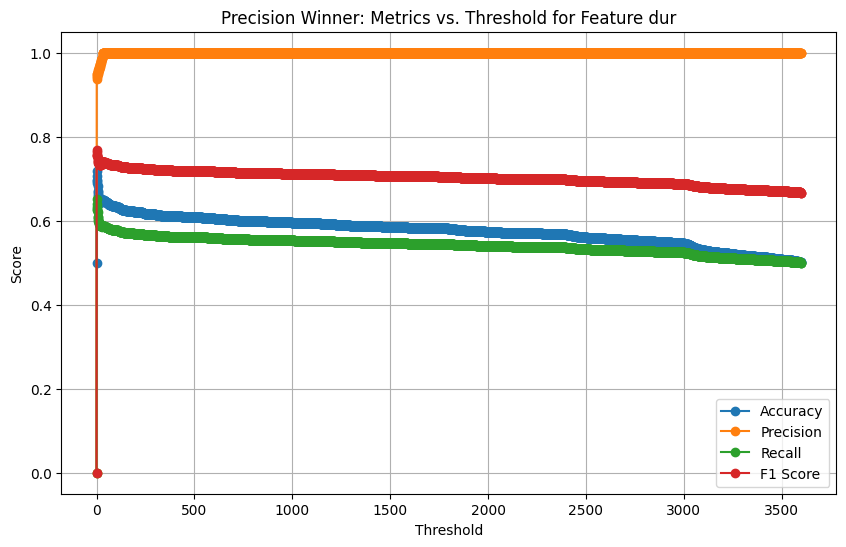

In [19]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

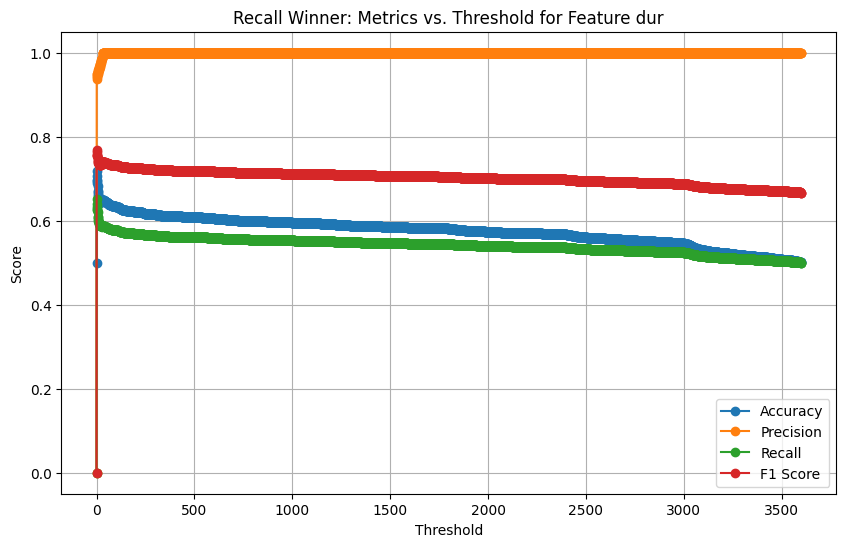

In [20]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

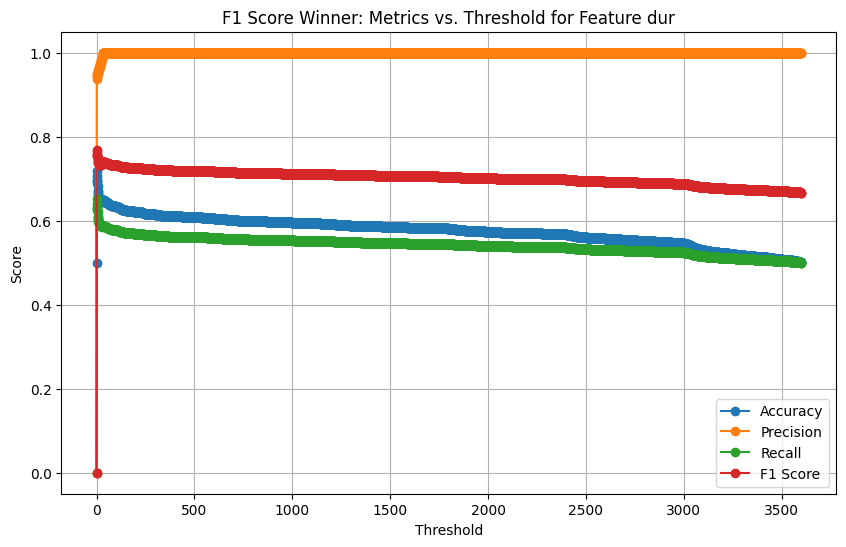

In [21]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

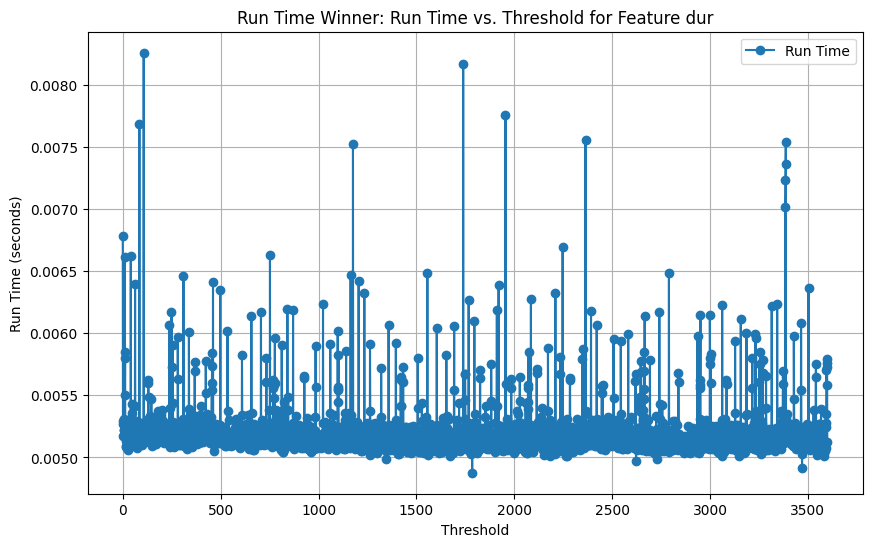

In [22]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [23]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur dur dan threshold 3516, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur dur dan threshold 1, menghasilkan recall 0.6515012455749312.
F1-score terbaik dicapai dengan fitur dur dan threshold 1, menghasilkan F1-score 0.7688380009283615.
Akurasi terbaik dicapai dengan fitur dur dan threshold 1, menghasilkan akurasi 0.7180600113228911.
Waktu running tercepat dicapai dengan fitur dur dan threshold 1785, dengan waktu running 0.0048773288726806 detik.
